# **Simulatie alleen parafine**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### **Constanten**

In [2]:
Tm = 54 + 273.15
dT = 0.5

l_l, rho_l, c_l = (0.15, 780, 2100)
l_s, rho_s, c_s = (0.24, 860, 2900)
L = 2.1e5 # J/kg

# x_staaf = 0.3 # (m) Staaf lengte
x = 0.1 #(m) Simluatie lengte
t = 1600 # (s) Simulatie tijd

T_0 = 35 + 273.15
T_x0 = 100 + 273.15
T_ref = Tm - dT

### **Variabelen die een functie van T zijn**

In [3]:
def theta_l(T):
    if T >= Tm + dT:
        return 1
    elif Tm - dT < T and T < Tm + dT:
        return (T - Tm + dT)/2/dT
    else:
        return 0

def theta_s(T):
    return 1 - theta_l(T)

def l_phi(T):
    return theta_l(T) * l_l + theta_s(T) * l_s

def rho_phi(T):
    return theta_l(T) * rho_l + theta_s(T) * rho_s

def dthetal_dT(T):
    if Tm - dT < T and T < Tm + dT:
        return 1/2/dT
    else:
        return 0

def cA(T):
    return theta_s(T)*rho_s*c_s + theta_l(T)*rho_l*c_l + ((rho_l*c_l - rho_s*c_s)*(T - T_ref) + rho_l*L) * dthetal_dT(T)

### **Oplossen**

In [5]:
dt = 0.004
dx = 0.00004

i_max, k_max = (int(x/dx), int(t/dt))
T = np.empty((k_max, i_max))
# T = np.memmap('T_grid/T_grid.dat2', dtype=np.float32, mode='w+', shape=(k_max, i_max))
T.fill(T_0)
T[:,:1] = T_x0
    
try:
    for k in tqdm(range(0, k_max-1)):
        for i in range(1, i_max-1):

            cfl_term = l_phi(T[k,i+1]) * dt / (dx**2 * cA(T[k,i]))
            if cfl_term > 0.5:
                raise ValueError(f"CFL condition violated: {cfl_term}. Reduce dt or increase dx.")
            
            T[k + 1, i] = T[k,i] + (dt/dx**2/cA(T[k,i]))*((l_phi(T[k,i+1])-l_phi(T[k,i]))*(T[k,i+1]-T[k,i])+l_phi(T[k,i])*(T[k,i+1]-2*T[k,i]+T[k,i-1]))
except ValueError as e:
    raise e
except Exception as e:
    print(e)

100%|██████████| 399999/399999 [2:31:34<00:00, 43.98it/s]  


In [6]:
np.savetxt('opgeslagen_np_arrays/T-dt-{}-dx-{}-dT-{}.txt'.format(dt, dx, dT), T, fmt='%d')

In [ ]:
# np.loadtxt('test1.txt', dtype=int)

Smeltfront positie als functie van de tijd voor verschillende dt en dx


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


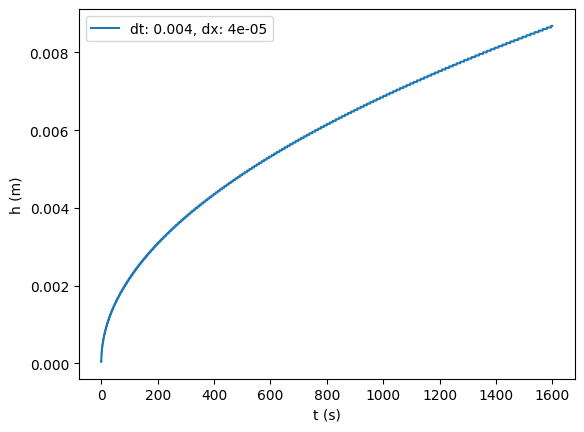

In [7]:
print('Smeltfront positie als functie van de tijd voor verschillende dt en dx')

def calc_melt_height(T, dt, dx):
    melt_height = []
    melt_time = []
    for idx, k in enumerate(T):
        pos = np.argmin(np.array(k)>Tm)
        melt_height.append(pos*dx)
        melt_time.append(idx*dt)
        
    return melt_height, melt_time

melt_height_var1, melt_time_var1 = calc_melt_height(T, dt, dx)

plt.figure()
plt.plot(melt_time_var1,melt_height_var1, label='dt: {}, dx: {}'.format(dt, dx))
plt.xlabel('t (s)')
plt.ylabel('h (m)')
plt.legend()
plt.savefig('figs/smeltfront-dx-dt.eps')
plt.show()